# Introduction

This Jupyter Notebook introduces [Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) along with [KDEpy](https://kdepy.readthedocs.io/en/latest/).
Roughly speaking, kernel density estimation is one approach to solving the following problem.

> **Problem.** Given a set of $N$ data points $\{x_1, x_2, \dots, x_N\}$, estimate the probability density function from which the data is drawn.

There are roughly two approaches to solving the problem presented above:

1. Assume a **parametric form**, for instance the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution), and estimate the parameters $\mu$ and $\sigma$. These parameters uniquely determine the distribution, and are typically found using the [maximum likelihood principle](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). The advantage of this approach is that we only need to estimate a few parameters, while the disadvantage is that the chosen parametric form might not fit the data very well.
2. Use **kernel density estimation**, which is a non-parametric method -- we let the data speak for itself. The idea is to place a *kernel function* $K$ on each data point $x_i$, and let the probability density function be given by the sum of the $N$ kernel functions.

Assuming a parametric form is a perfectly valid approach, especially if there is evidence suggesting the presence of a theoretical distribution.
For [exploratory data analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis) we might want to plot a distribution without assuming too much however, and this is where kernel density estimation and KDEpy can help us.

In [30]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from KDEpy import FFTKDE

np.random.seed(123)  # Seed random number generator for reproducible results

distribution = norm()  # Create normal distribution
data = distribution.rvs(32)  # Draw random samples

## The histogram

A KDE may be thought of as an extension to the familiar [histogram](https://en.wikipedia.org/wiki/Histogram). 
The purpose of the KDE is to estimate an unknown probability density function given data drawn from it. 
A natural first thought is to use a histogram – it’s well known, simple to understand and works reasonably well.

To see how the histogram performs on the data generated above, we'll the true distribution alongside a histogram. 
As seen below, the histogram does a fairly poor job.
- The location of the bins and the number of bins both seem arbitrary.
- The estimated distribution is discontinuous, while the true distribution is smooth.

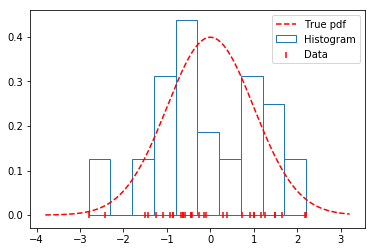

In [34]:
x = np.linspace(np.min(data) - 1, np.max(data) + 1, num=2**10)
plt.hist(data, density=True, label='Histogram', edgecolor='#1f77b4', color='w')
plt.scatter(data, np.zeros_like(data), marker='|', c='r', label='Data', zorder=9)
plt.plot(x, distribution.pdf(x), label='True pdf', c='r', ls='--')
plt.legend(loc='best');

## Centering the histogram

In an effort to reduce the arbitrary placement of the histogram bins, we center a rectangular function $K$ on each data point $x_i$ and sum those functions to obtain a probability density function. 

$$\hat{f}(x) = \frac{1}{N} \sum_{i=1}^N K \left( x-x_i \right) \quad \text{ where } \quad K = \text{rectangular function}$$

Let's see what this looks like graphically.

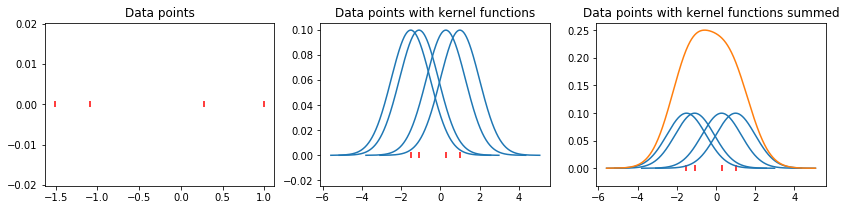

In [54]:
np.random.seed(123)
data = distribution.rvs(4)

plt.figure(figsize=(14, 3)); plt.subplot(1, 3, 1)
plt.title('Data points')
plt.scatter(data, np.zeros_like(data), marker='|', c='r', label='Data')

plt.subplot(1, 3, 2); plt.title('Data points with kernel functions')
plt.scatter(data, np.zeros_like(data), marker='|', c='r', label='Data')
for d in data:
    x, y = FFTKDE().fit([d])()
    plt.plot(x, y / 4, color='#1f77b4')
    
plt.subplot(1, 3, 3); plt.title('Data points with kernel functions summed')
plt.scatter(data, np.zeros_like(data), marker='|', c='r', label='Data')
for d in data:
    x, y = FFTKDE().fit([d])()
    plt.plot(x, y / 4, color='#1f77b4')
    
x, y = FFTKDE().fit(data)()
plt.plot(x, y, color='#ff7f0e');

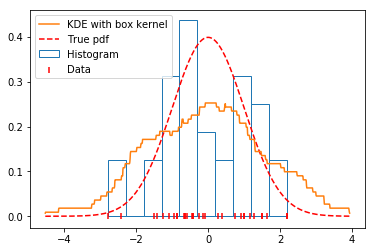

In [42]:
np.random.seed(123)
data = distribution.rvs(32)

# Use a box function with the FFTKDE to obtain a density estimate
x, y = FFTKDE(kernel='box', bw=1).fit(data).evaluate()

plt.plot(x, y, zorder=10, color='#ff7f0e', label='KDE with box kernel')
plt.scatter(data, np.zeros_like(data), marker='|', c='r', label='Data', zorder=9)
plt.hist(data, density=True, label='Histogram', edgecolor='#1f77b4', color='w')
plt.plot(x, distribution.pdf(x), label='True pdf', c='r', ls='--')
plt.legend(loc='best');

## Choosing a smooth kernel

To alleviate the problem of discontinuity, we substitute the rectangular function used above for a gaussian function. 

$$K = \text{rectangular function} \quad \to \quad K = \text{gaussian function}$$

The gaussian is smooth, and so the result of our estimate will also be smooth.

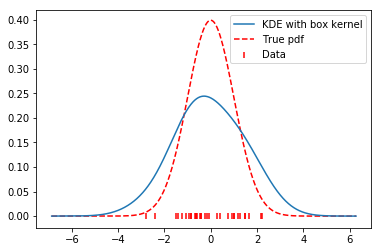

In [43]:
# Use the FFTKDE with a smooth Gaussian
x, y = FFTKDE(kernel='gaussian', bw=1).fit(data).evaluate()

plt.plot(x, y, zorder=10, label='KDE with box kernel')
plt.scatter(data, np.zeros_like(data), marker='|', c='r', label='Data')
plt.plot(x, distribution.pdf(x), label='True pdf', c='r', ls='--')
plt.legend(loc='best');

## Selecting a suitable bandwidth

To control for the bandwidth $h$ of the kernel, we'll add a factor $h$ to the equation above.

$$\hat{f}(x) = \frac{1}{N} \sum_{i=1}^N K \left( x-x_i \right) \quad \to \quad \hat{f}(x) = \frac{1}{N} \sum_{i=1}^N K \left( x-x_i \right)$$

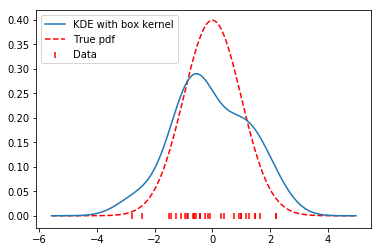

In [46]:
x, y = FFTKDE(kernel='gaussian', bw='silverman').fit(data).evaluate()

plt.plot(x, y, zorder=10, label='KDE with box kernel')
plt.scatter(data, np.zeros_like(data), marker='|', c='r', label='Data')
plt.plot(x, distribution.pdf(x), label='True pdf', c='r', ls='--')
plt.legend(loc='best');

## Methods of computation

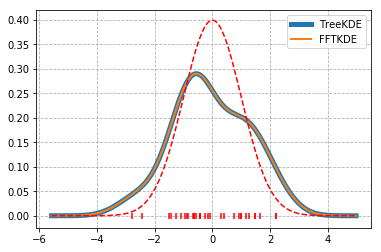

In [47]:
from scipy import stats
from KDEpy import TreeKDE

x, y = TreeKDE(kernel='gaussian', bw='silverman').fit(data)()
plt.plot(x, y, zorder=10, lw=5, label='TreeKDE')

y = FFTKDE(kernel='gaussian', bw='silverman').fit(data).evaluate(x)
plt.plot(x, y, zorder=10, lw=2, label='FFTKDE')

plt.scatter(data, np.zeros_like(data), marker='|', color='r', zorder=15)
plt.plot(x, distribution.pdf(x), ls='--', color='r', zorder=20)
plt.grid(True, ls='--', zorder=-15); plt.legend();

## Extensions to the problem